<a href="https://colab.research.google.com/github/mgonzal1/nma_wombat_connectivy_project/blob/master/connectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import sklearn.metrics
import ipywidgets as widgets 
import numpy as np
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [3]:
#@title Representative session
#@markdown As first step, lets choose 1 session to start trainning the model. Let's see which session has more neurons in the areas that we are going to use and how many neurons it has.
@widgets.interact
def get_representative_session(min_areas=(0,7)):
  """ To simplify the model we are selecting a session recording with most of the regions represented.
    This interactive function help us to decide the session based on the minimal regions represented and number of 
    total neurons recorded.

  """
  print("")
  brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                  ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                  ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                  ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                  ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                  ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                  ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                  ]
  regions = ["visual ctx", "thal", "hipp", "non-visual ctx", "midbrain", "basal ganglia", "cortical subplate"]
  for i in range (0,38):
    session = alldat[i]
    brain_areas = set(session['brain_area'])
    representative = []
    neurons_in_area = []
    for group in brain_groups:
        representative.append(any(area in brain_areas for area in group))
    
    if(representative.count(True)>min_areas):
      print("Session:" , i, "Total neurons:",session['brain_area'].shape[0])
      #labels, sizes = np.unique(session['brain_area'], return_counts=True)
      #print(sizes)
      #fig = plt.figure()
      #ax = fig.add_axes([0,0,1,1])
      #ax.bar(regions,representative)
      #ax.set_title("Session {}".format(i))
      #plt.show()


interactive(children=(IntSlider(value=3, description='min_areas', max=7), Output()), _dom_classes=('widget-int…

In [6]:
# SET DEFAULTS
trial_time = 2.5
session=12
n_sessions = len(alldat)
data_set = alldat[session]

In [9]:
#@title General functions to get data


def get_spks_from_area(dat,brain_area):
  n_neurons = dat['spks'].shape[0]
  index_neurons = np.zeros(n_neurons,dtype=bool)

  for neuron in range(n_neurons):
    index_neurons[neuron] = dat['brain_area'][neuron] in brain_area

  area_data = (dat['spks'][index_neurons,:,:].sum(axis=2)/trial_time).T
  return area_data, index_neurons

def get_visual_ctx(data_set):
  # TODO: Change to the corrrect areas
  visual_ctx = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]
  visual_data, _ = get_spks_from_area(data_set, visual_ctx)
  return visual_data

def get_motor_ctx(data_set):
  #TODO : Change to the correct areas
  motor_ctx = ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"]
  motor_data, _ = get_spks_from_area(data_set, motor_ctx)
  return motor_data

def get_stimulus(data_set):
  """
   Args: 
      data_set: (map) Subset of alldat
      
   Returns:
      stims[nTrials x 3]  bias: constant with ones
                          stim_left: contrast level for the right stimulus.
                          stim_right: contrast level for left stimulus.
  """


  stims = data_set['contrast_left'], data_set['contrast_right']
  stims = np.array(stims).T
  n_trials = stims.shape[0]
  stims = np.column_stack((np.ones(n_trials),stims))
  return stims

def get_response(data_set):
  """
   Args: 
      data_set: Subset of alldat

   Returns:
        np.array: which side the response was (-1, 0, 1). Choices for the right stimulus are -1.
  """
  response =  np.array(data_set['response'])
  return response

def get_binary_response(data_set):
  """
   To simplify the model we ares going to use a binary response instead of the 3 possible values: left, no-action, right
   to true or false comparing the stimulus to the expected actions. 

   Args: 
      data_set: Subset of alldat

   Returns:
        binary (np.array boolean) : Returns True or False
  """
  visual_stims = get_stimulus(data_set)
  vis_left, vis_right = [visual_stims[:,1], visual_stims[:,2]]
  response = get_response(data_set)
  binary_response = np.sign(response)==np.sign(vis_left-vis_right)
  return binary_response

def get_validation_set(data_set):
  """
  Get a subset of alldat for validation purposes. This should be ~5%-10% of all the data.

  Returns:
    map: dat['spks']: neurons by trials by time bins. Time bin = 10ms.
         dat['brain_area']: brain area for each neuron recorded.
         dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
         dat['contrast_left']: contrast level for left stimulus.
         dat['response']: which side the response was (-1, 0, 1). Choices for the right stimulus are -1.
         dat['response_times']: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and always does!).
  """
  stims=get_stimulus(data_set) 
  spk= data_set['spks']
  # # create training and testing vars
  stim_train, stim_test, spk_train, spk_test = train_test_split(stims, spk, test_size=0.1)

  return stim_train, stim_test, spk_train, spk_test

# MODEL1:  Encodig from visual stimulus

Using Multiple Linear Regresion

Testing with k-fold cross-validation

**Parameters:**
*   visual stimulus : [nTrials x 2] Contrast on left and right
*   visual trials matrix : [nTrials x Neurons]

**Returns**
*  A1 matrix [2x ntrials]

**TODO**
*   Calculate MSE and R2 per Neuron
*   Test with more sessions, the MSE decrease?


In [12]:
visual_dat = get_visual_ctx(data_set)
stim = get_stimulus(data_set)
print(visual_dat.shape, stim.shape)

model = LinearRegression(fit_intercept=False).fit(stim, visual_dat) 

A1 = model.coef_.T

visual_dat_hat = stim @ A1
mse = np.mean( (visual_dat-visual_dat_hat)**2 )

r2_metrics =  sklearn.metrics.r2_score(visual_dat,visual_dat_hat)

print(f'MSE {mse}')
print(f'R2 {r2_metrics}')




(300, 34) (300, 3)
MSE 3.9932810695570886
R2 0.032113610602124414


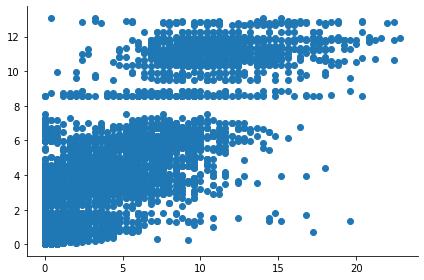

In [13]:
plt.scatter(visual_dat.flatten(), visual_dat_hat.flatten()) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

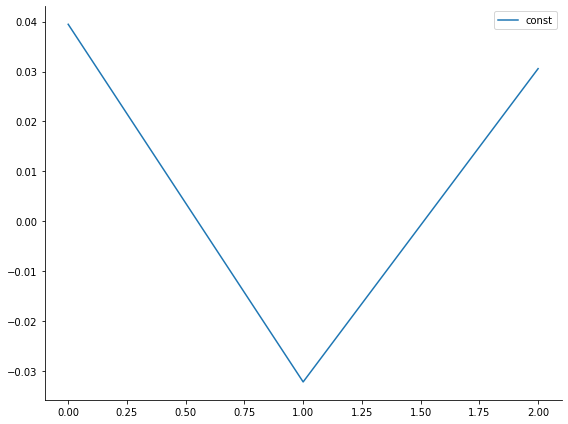

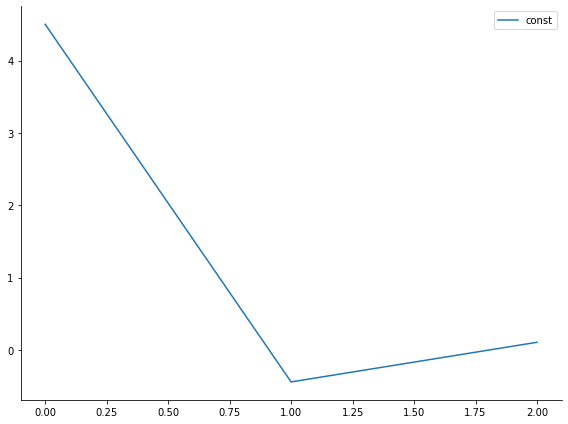

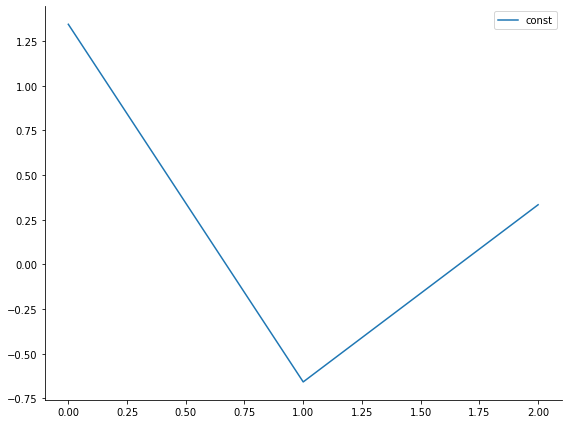

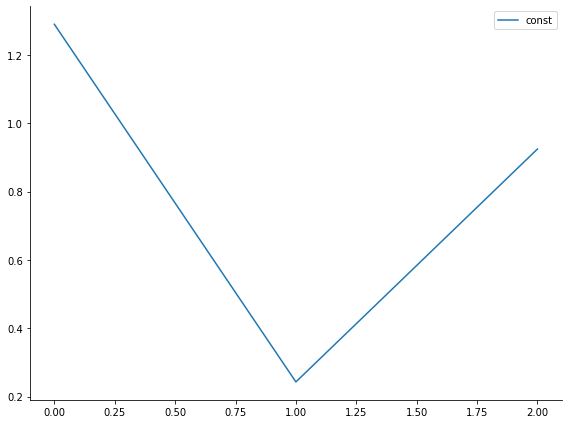

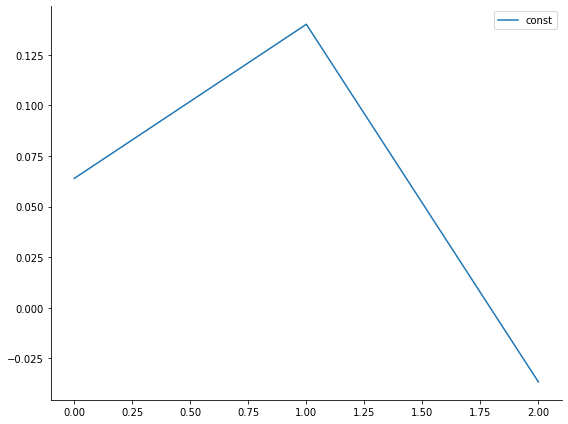

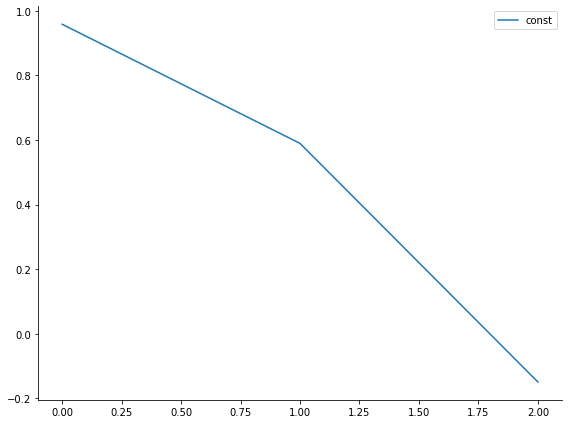

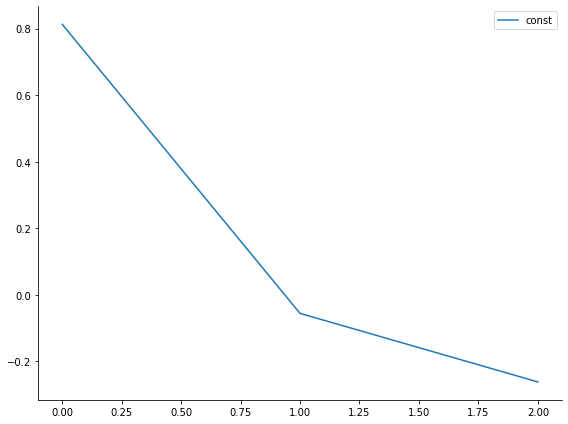

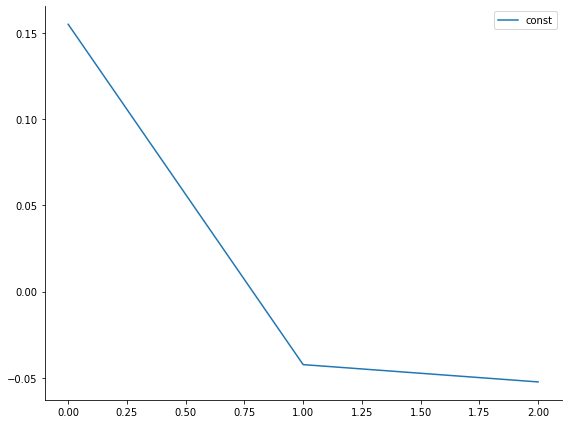

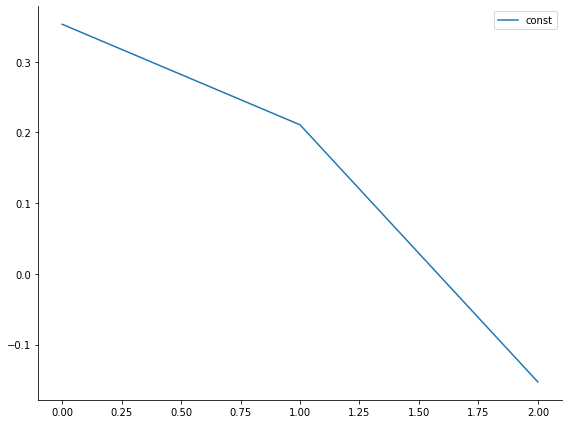

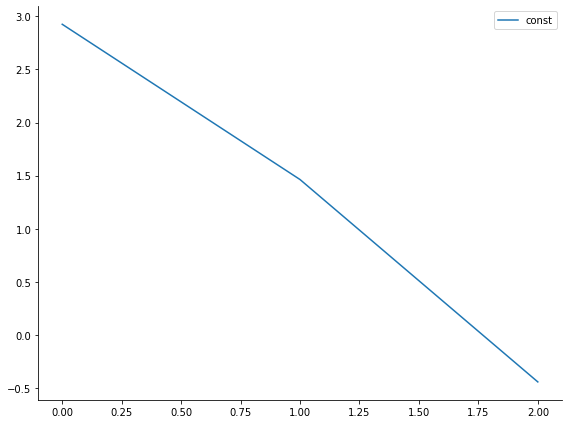

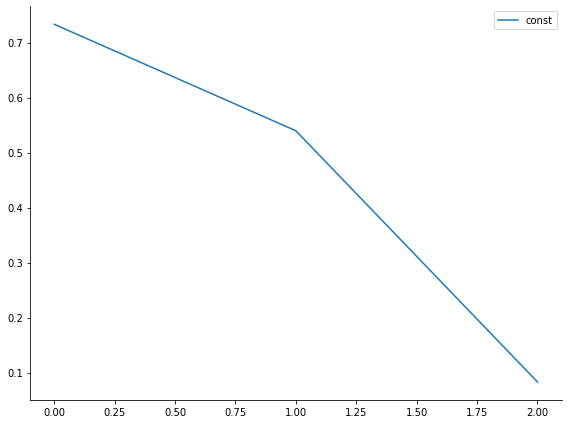

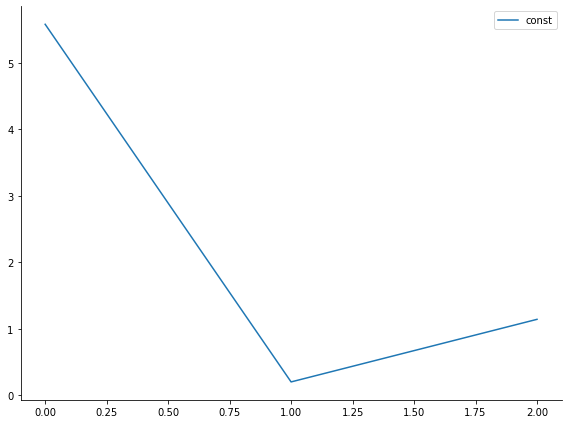

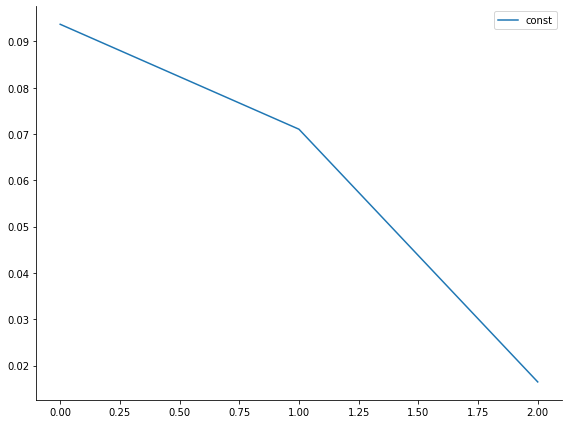

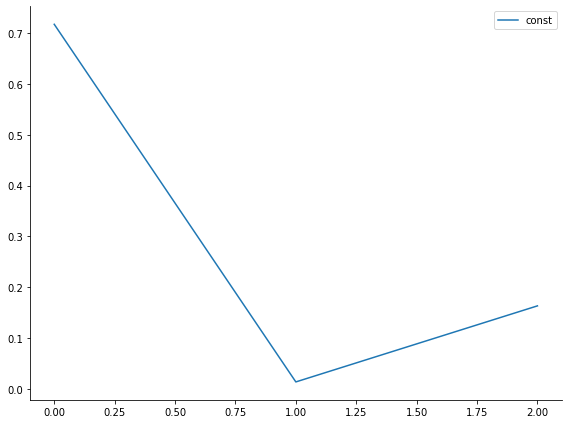

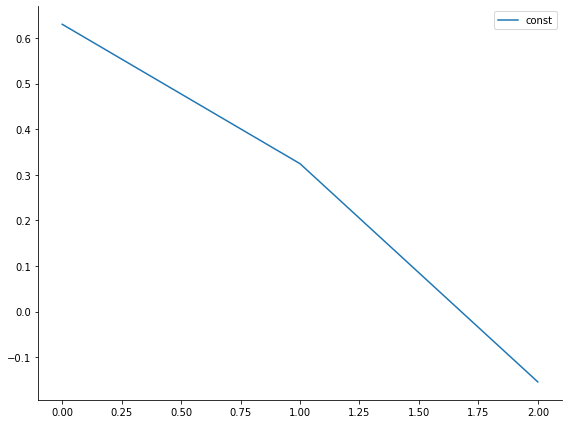

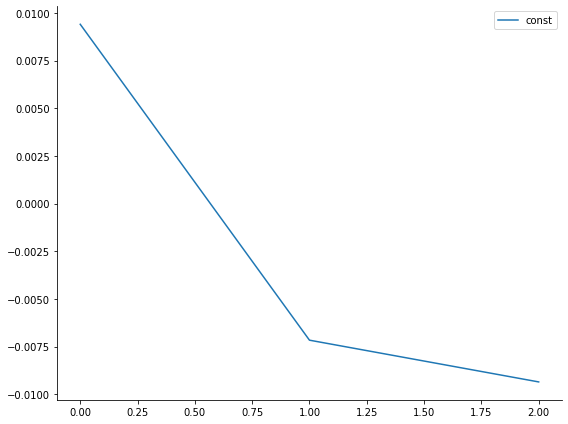

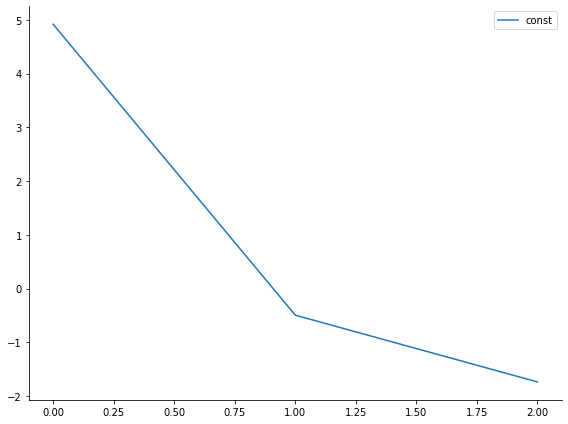

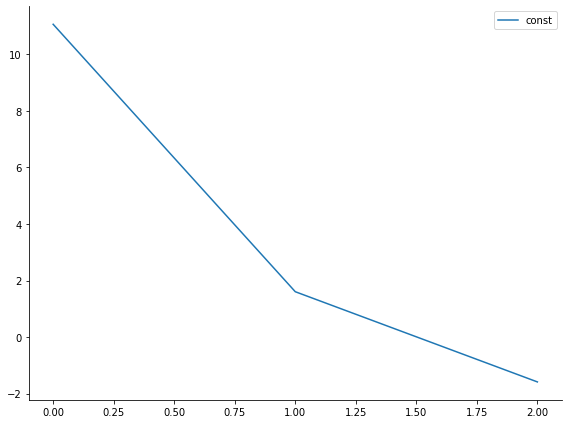

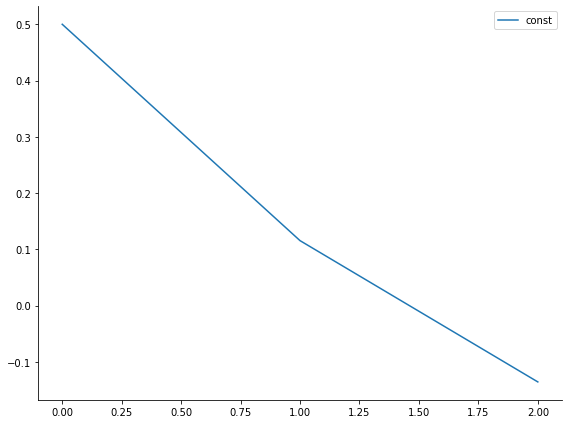

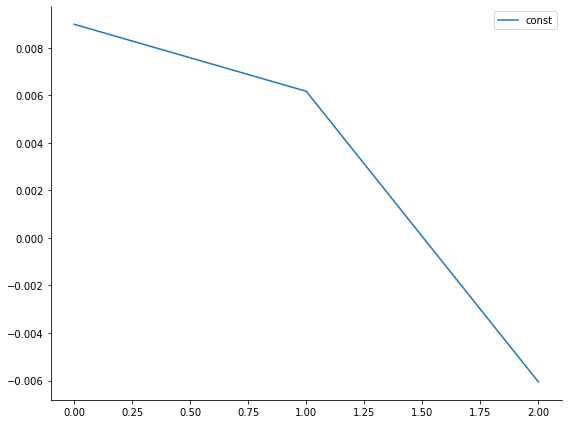

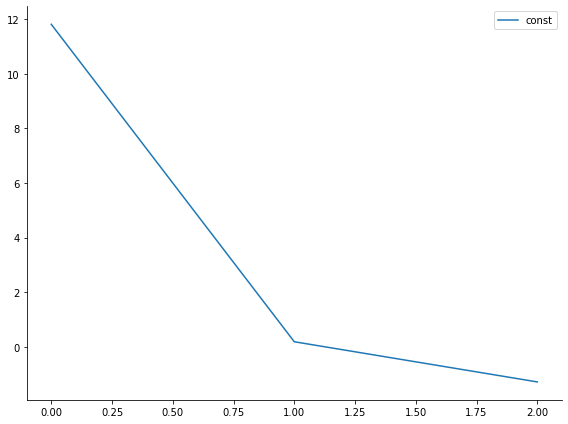

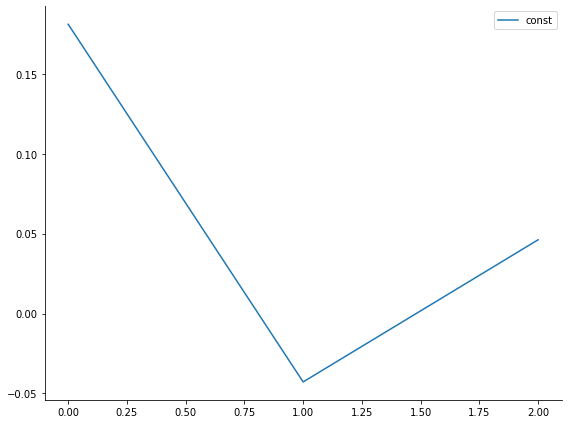

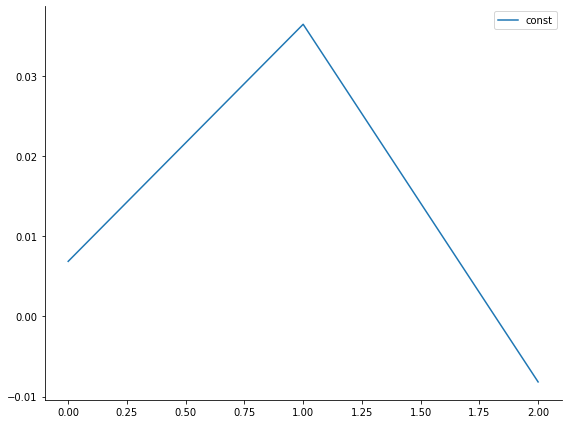

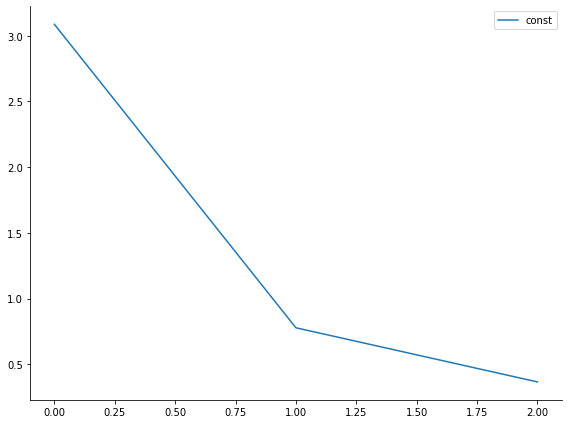

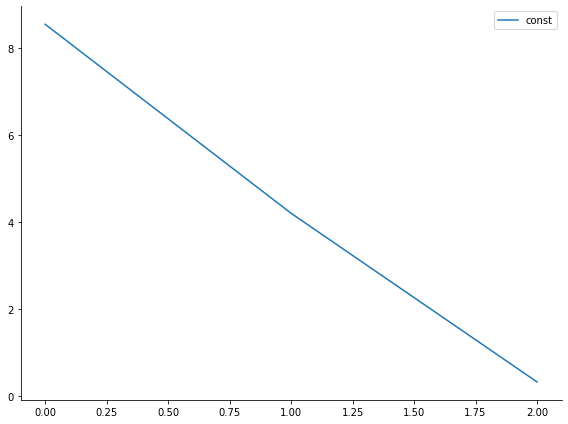

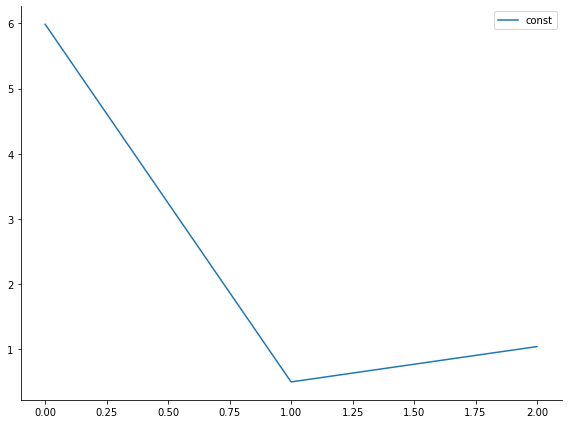

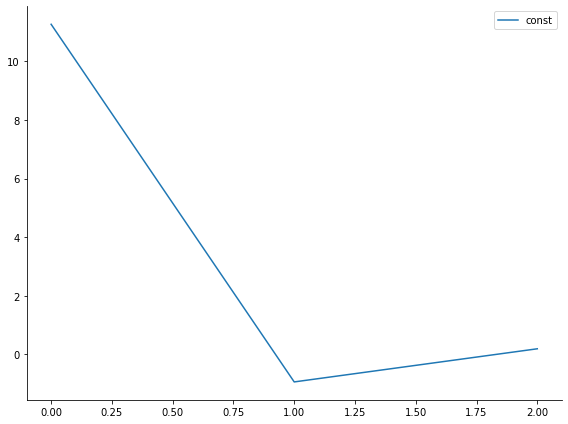

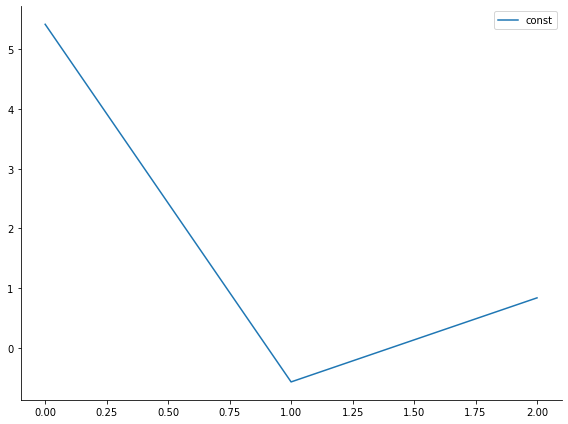

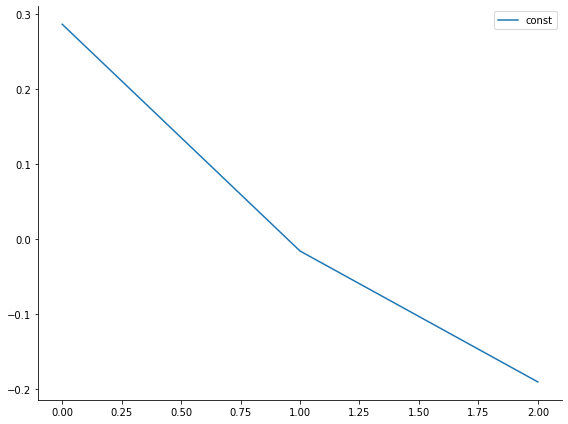

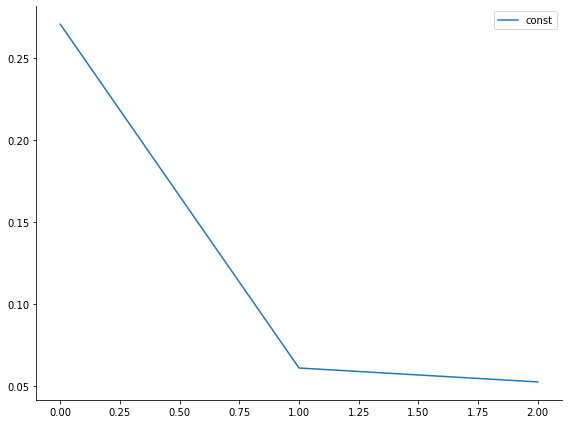

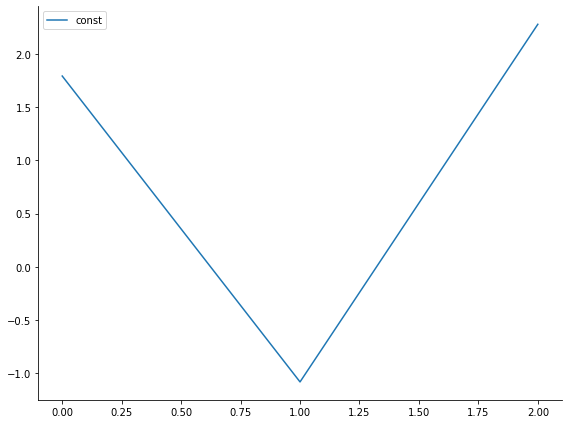

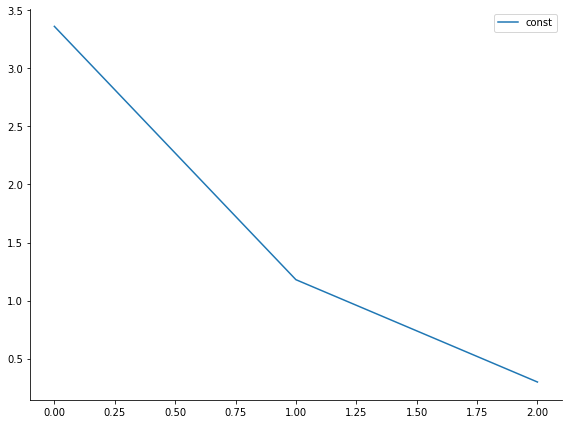

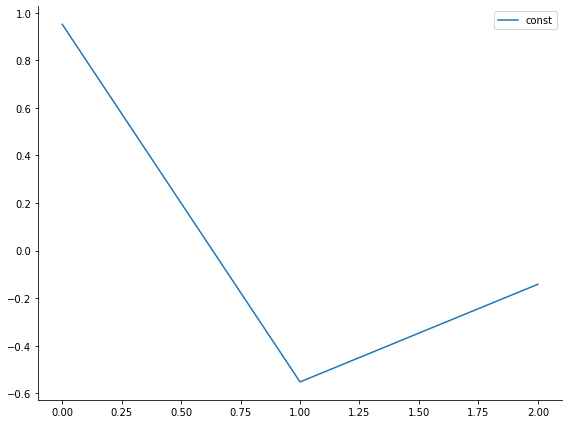

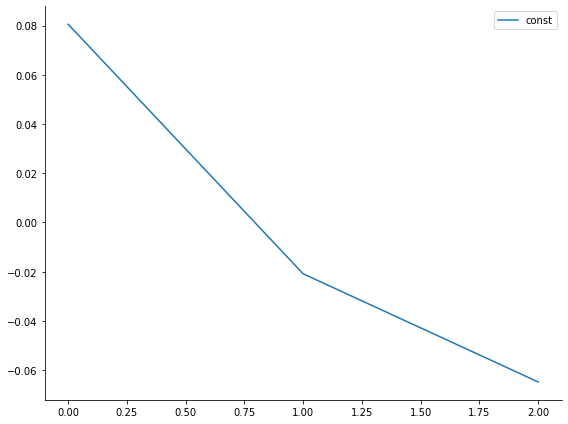

In [15]:
n_visual_dat_= np.zeros(visual_dat.shape[1])
n_visual_dat_hat= np.zeros(visual_dat.shape[1])
n_mse = np.zeros(visual_dat.shape[1])
n_r2_metrics = np.zeros(visual_dat.shape[1])

for j in range(visual_dat.shape[1]):

#  index_n[n_] = [visual_dat][n_] in visual_dat

  n_visual_dat =visual_dat[:,j]


  model = LinearRegression(fit_intercept=False).fit(stim, n_visual_dat)


  A1_n = model.coef_.T


  n_visual_dat_hat = stim @ A1_n
  n_mse [j]= np.mean( (n_visual_dat-n_visual_dat_hat)**2 )
  n_r2_metrics [j] =  sklearn.metrics.r2_score(n_visual_dat,n_visual_dat_hat)

  
  fig,ax = plt.subplots(figsize=(8,6))
  plt.plot(model.coef_)
  plt.legend(['const','stim_L', 'stim_R'])

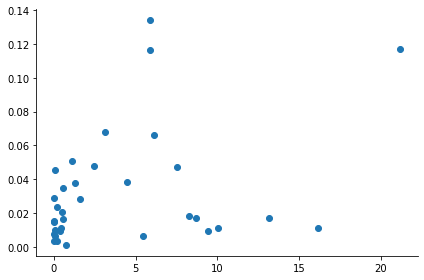

In [16]:
plt.scatter(n_mse.flatten(), n_r2_metrics.flatten())

In [17]:
def cross_validation(stim_train, visual_train, n_splits):
  # Initialize the split method
  kfold_iterator = KFold(n_splits)
  mse_all =  []
  r2_all = []

  for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(stim_train)):
      
      # Split up the overall training data into cross-validation training and validation sets
      stim_cv_train = stim_train[train_indices]
      visual_cv_train = visual_train[train_indices]

      #Let's ignore the test data in our model 
      # stim_cv_val = stim_train[val_indices]
      # visual_cv_val = visual_train[val_indices]

      # MLR
      modelA1 = LinearRegression(fit_intercept=False).fit(stim, visual_dat) 
      theta_hats = modelA1.coef_.T

      # Compute MSE
      visual_cv_train_hat =  stim_cv_train @ theta_hats
      mse_this_split = np.mean((visual_cv_train-visual_cv_train_hat)**2 )
      mse_all.append(mse_this_split)

      #Compute R2
      r2_this_split = sklearn.metrics.r2_score(visual_cv_train,visual_cv_train_hat)
      r2_all.append(r2_this_split)

  return mse_all, r2_all
 

In [27]:
@widgets.interact
def interactive_cross_val(num_splits=(0,50)):
  mse_all, r2_all = cross_validation(stim, visual_dat, num_splits)
  f, ax = plt.subplots(figsize=(8, 3))
  ax.boxplot(r2_all, vert=False, widths=.7)
  ax.scatter(r2_all, np.ones(num_splits))
  ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average R2: {np.mean(r2_all):.2%}"
  )
  ax.spines["left"].set_visible(False)


interactive(children=(IntSlider(value=25, description='num_splits', max=50), Output()), _dom_classes=('widget-…

# MODEL3:  Decoding from motor
Logistic Regression no penalty

**Parameters:**
*   Motor matrix [nTrials x neurons].
*   Reponses 3 categories.

**TODO List**
*   Change to get 3 categories of response (Left, Right, None).
*   Filter trials to use only trials that succed to perform the action.


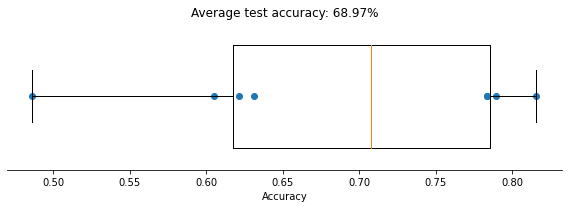

In [28]:
# obtenemos matrices 'y' y 'x'
motor_dat = get_motor_ctx(data_set)
binary_dat = get_binary_response(data_set)

#definimos el modelo & ajustamos los datos
log_reg = LogisticRegression(penalty="none")
log_reg.fit(motor_dat, binary_dat) 

# predicciones
binary_dat_hat = log_reg.predict(motor_dat)

#accuracy
similarity = (binary_dat == binary_dat_hat)   #nos da booleans de [true false] de predicciones correctas
accuracy = np.sum(similarity)/len(binary_dat)

#crossvalidation 
accuracies = cross_val_score(LogisticRegression(penalty='none'), motor_dat, binary_dat, cv=8)

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)